# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [4]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

For PCA dimensions, my guess is that a combined component of "Fresh", "Milk", and "Grocery" will be the first principal component. In my opinion, "Fresh", "Milk", and "Grocery" all fall under the more general category of "groceries".

For ICA dimensions, my guess is that "Detergents_Paper" will be a basis vector of ICA. Out of all product categories (features) in our data, "Detergents_Paper" seems like the most different/independent category compared to the rest.

### PCA

In [5]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=len(data.columns))
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer:

Looking at PCA's explained variance ratio, we see that the variance drops off significantly after the second principle component/dimension. In particular, the first to second principle components explain 46% and 41% of the total variance, respectively. However, the third principle component only explains 7% of the total variance.

Based on the above reasoning, if I were to use PCA on this dataset, I would choose 2 dimensions for my analysis.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer:

The first dimension (first principle component) is basically the "Fresh" feature, but negative. Looking at the first principle component, we see the first value (the value corresponding to "Fresh") is -0.9765, whereas all other values are much closer to 0. The fact that this value is negative is acceptable, as this means we found the appropriate eigenvector, just pointing in the opposite direction.

The second dimension (second principle component) seems to represent a weighted combination of "Grocery", "Milk", and "Detergents_Paper", since the values corresponding to the aforementioned features in the second principle component seem to be the largest.

From the analysis above, it seems we can determine our customer segments using just these two dimensions. Using the two principle components decribed above, we can run unsupervised clustering algorithms to discover customer segments.

Note that the "Frozen" and "Delicatessen" features do not play a large role in our reduced feature set, because the volume of sales in those categories are too low to create meaningful customer segments. If there is a particular category of customers that focus on purchasing "Frozen" or "Delicatessen" products, their volume is too low for us to allocate resouces to target them, relative to other customer categories.

### ICA

In [6]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA

# Adjust the data to have center at the origin first
data_norm = data.apply(lambda x: (x - np.mean(x)))

# Since ICA gives different results each time, I will run ICA 3 times
# and visually inspect all components_ matrices,
# to see if results are generally similar or not
for i in range(3):
    ica = FastICA()
    ica.fit(data_norm)
    comp = ica.components_
    
    print 'Random Polarity ICA Run ' + str(i)
    print comp[np.argsort(comp[:,0])]
    print '\n'

# From the results in the above loop, we will see the ICA
# components' polarity is random. Let's fix the polarity
# to try to spot some patterns
for i in range(3):
    ica = FastICA()
    ica.fit(data_norm)
    comp = ica.components_
    
    # ICA gives arbitrary polarity for components,
    # so standardize the polarity such that
    # the first column's value is always positive
    for row in comp:
        if row[0] < 0:
            row *= -1
    
    print 'Fixed Polarity ICA Run ' + str(i)
    print comp[np.argsort(comp[:,0])]
    print '\n'

Random Polarity ICA Run 0
[[ -3.97578076e-06   8.57847562e-07   6.17827212e-07   6.78000548e-07
   -2.04717856e-06   1.04692692e-06]
 [  1.53349053e-07   9.84677034e-06  -5.80583996e-06  -3.64603540e-07
    3.30306336e-06  -6.05950613e-06]
 [  2.11306929e-07  -1.89394251e-06   6.37135406e-06   4.18237255e-07
   -6.80800889e-07  -1.42817184e-06]
 [  3.01029740e-07  -2.29485616e-06  -1.20908131e-05   1.46096381e-06
    2.82124136e-05   5.73393390e-06]
 [  3.86380270e-07   2.19519482e-07   6.01536821e-07   5.22065423e-07
   -5.10804173e-07  -1.80928307e-05]
 [  8.65268237e-07   1.40224019e-07  -7.74333414e-07  -1.11460886e-05
    5.56306851e-07   5.95250028e-06]]


Random Polarity ICA Run 1
[[ -8.65300549e-07  -1.40127942e-07   7.74464452e-07   1.11460544e-05
   -5.56877912e-07  -5.95258029e-06]
 [  1.53270808e-07   9.84715074e-06  -5.80457547e-06  -3.64817172e-07
    3.29948721e-06  -6.06009661e-06]
 [  2.11625364e-07  -1.89759828e-06   6.34940212e-06   4.21052392e-07
   -6.30093779e-07 

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer:

First, looking at results from "Fixed Polarity ICA Run [0-2]", we see that the last 3 vectors/rows of the unmixing matrices are consistent (rows 3-5, inclusive). Note all rows are zero-mean.

However, we cannot make any conclusions about the qualitative type of customer based on these 3 vectors, because their polarity is indeterminant. Looking at "Random Polarity ICA Run [0-2]", we can find the last 3 vectors from "Fixed Polarity ICA Run [0-2]", but with random polarity.

Unfortunately, I cannot draw any conclusions to the problem at hand, based on ICA. ICA is more applicable to problems like blind source separation (e.g. http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html). But for our particular case of customer segment discovery, it looks like ICA is not a good method to use.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer:

The advantages of K-Means clustering is that it is a fast way to perform clustering (in terms of computational runtime), compared to Gaussian Mixture Models. However, K-Means clustering only provides information about which cluster a data point belongs to, but no information about the likelihood/probability of that data point belonging to said cluster.

This is in contrast to clustering using Gaussion Mixture Models. Although it runs slower than K-Means, Gaussian Mixture Models can not only provide information about which cluster a data point belongs to, it can also provide the probability that a particular data point belongs to said cluster. Also, Gaussian Mixture Models can calculate more complex decision boundaries compared to K-Means.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [7]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [8]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


#### Using K-Means Clustering

In [9]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
num_clusters = 3
clusters = KMeans(n_clusters=num_clusters).fit(reduced_data)

print clusters

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [10]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [11]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 
centroids = clusters.cluster_centers_
print centroids

[[  1497.13461172  24998.27760147]
 [-24220.71188261  -4364.45560022]
 [  4106.90273941  -3168.41202086]]


/Users/gsung/anaconda/envs/ml_nd/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


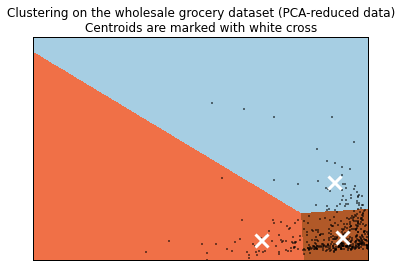

In [12]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#### Using Gaussian Mixture Model Clustering

In [13]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
clusters = GMM(n_components=num_clusters).fit(reduced_data)

print clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)


In [14]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [15]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 
centroids = clusters.means_
print centroids

[[   269.05318679  -6506.88683442]
 [-17879.18623839  10122.79246625]
 [  6987.95079141   4249.82914044]]


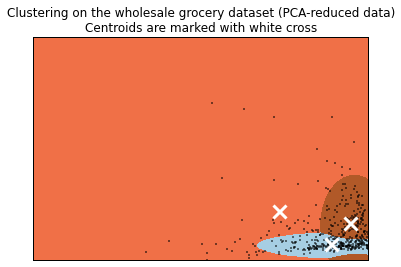

In [16]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

##### Zoom in on the plot above

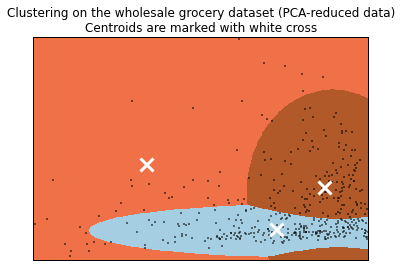

In [17]:
# Same plot as above, but zoomed-in
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min + 0.6*(x_max-x_min), x_max)
plt.ylim(y_min, y_max - 0.5*(y_max-y_min))
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer:

First, note that the horizontal axis is our first principle component from PCA, which is the component dominated by the "Fresh" category. Also note the horizontal axis is negative, so datapoints on the left of the plot represent customers who placed relatively large orders of "Fresh" items. The vertical axis is our second principle component from PCA, which is a combination of "Grocery", "Milk", and "Detergents_Paper". The datapoints on the top of the plot represent customers who placed large orders of groceries/milk/detergents/paper.

Recall that "Frozen" and "Delicatessen" categories are not represented in our 2 chosen principal components, since the quantities of frozen and delicatessen products are too small compared to the other categories. This renders frozen and delicatessen categories less relevant.

Qualitatively, the blue cluster represents customers who buy very little groceries/milk/detergents/paper, and little to moderate quantities of fresh produce. The customers represented by the blue cluster appear to be restaurants.

The brown cluster represents customers who buy very little fresh produce, but moderate to large quantities of groceries/milk/detergents/paper. The customers represented by the brown cluster appear to be grocery stores and supermarkets.

The orange cluster represents customers not included in the blue and brown clusters, and it's hard to pinpoint an exact category of customers for the orange cluster.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer:

For deciding between PCA and ICA, I felt PCA worked better for the problem at hand. For more details, see answers to questions 3 and 4.

Deciding between K-Means and Gaussian Mixture Model (GMM) clustering, I felt GMM gave more insight into the data. Looking at the plots for both K-Means and GMM clustering methods (question 6), the plot using GMM clustering made more intuitive sense, in terms of valid clustering decision boundaries.

**9)** How would you use that technique to help the company design new experiments?

Answer:

As seen from our analysis using PCA and GMM clustering, we can find two general customer segments: restaurants and grocery stores / supermarkets. However, when running PCA, we have effectively removed all of the smaller customers from consideration, because their order quantities are too small to account for significant variance.

One new experiment the company may be interested to run is to analyze the smaller customers, to determine if there are any significant customer segments in this subset of customers. The smaller customers may place less orders, but there could be a category of small customers that are very vocal on social media for example, and those type of customers would have a higher importance than their order quantities would imply. We can reduce the dataset by only including the customers whose total order quantity is less than X monetary units, then perform PCA and GMM clustering on the reduced dataset.

**10)** How would you use that data to help you predict future customer needs?

Answer:

Based on the analysis of our data, we have concluded that the two main customer segments of concern are the restaurants and grocery stores / supermarkets, who mainly purchase fresh produce and groceries/milk/detergents/paper, respectively.

From this analysis, we can infer that any price and/or quality changes in our fresh produce will greatly affect our large restaurant customers. Also, andy price and/or quality changes in our groceries/milk/detergents/paper products will greatly affect our large grocery store / supermarket customers.

Also, for the restaurant customers, delivering fresh produce in the evenings may be bad for them, since the restaurants would want their fresh produce delivered in the morning so they can serve fresh food to their customers during the day. Since restaurant customers are an important customer segment, I would advise re-instating the morning delivery option.